## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report
from message_ix.tools.add_dac import get_values

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [ ]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

## Run SSP_dev DAC baseline scenario
**Clone and create SSP_dev DAC baseline scenario**

In [48]:
SSPs = ["SSP1","SSP2","SSP5"]
mpens = ["mpen1","mpen2","mpen3","mpen4","mpen5"]
scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']

scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
             {f"1000f_v0.13_dac_{mpen}": [] for mpen in mpens} 
             for ssp in SSPs
            }


In [82]:
colors = {"SSP1":"tab:blue","SSP2":"tab:orange","SSP5":"tab:green",}
lines = {"mpen1":"-","mpen2":"--","mpen3":"-.","mpen4":":","mpen5":(0, (3, 1, 1, 1, 1, 1))}

In [50]:
for k,v in scenarios.items():
    for k1,v1 in v.items():
        scen = message_ix.Scenario(mp, model=k, scenario=k1)
        acts = get_values(scen,"ACT").droplevel(["mode","time"])
        removal = (acts.loc[:, scenariotec, :, :]["lvl"].unstack().fillna(0)
                   .groupby(["node_loc"]).sum())
        removal.loc["World"] = removal.sum(axis=0)
        scenarios[k][k1] = removal
        


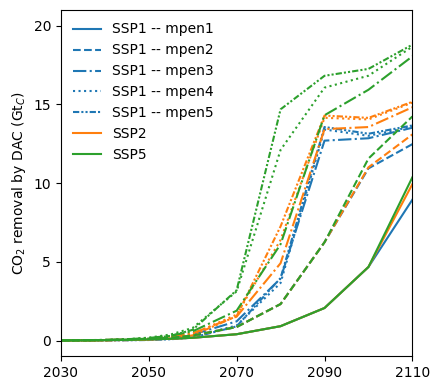

In [83]:
plt.figure(figsize=(4.5,4))
for ssp in SSPs:
    for mpen in mpens:
        model = f"SSP_dev_{ssp}_v0.1_dac"
        scenario = f"1000f_v0.13_dac_{mpen}"
        
        if ssp == "SSP1":
            kwargs = {"label": f"{ssp} -- {mpen}"}
        elif ssp != "SSP1" and mpen == "mpen1":
            kwargs = {"label": f"{ssp}"}
        else:
            kwargs = {}
        
        plt.plot(scenarios[model][scenario].div(1000).loc["World"], ls=lines[mpen], c=colors[ssp], **kwargs)

plt.ylim(-1,21)
plt.xlim(2030,2110)
plt.xticks(range(2030,2120,20))
plt.yticks(range(0,25,5))
plt.ylabel("CO$_2$ removal by DAC (Gt$_C$)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("dac_ssp.jpeg",dpi=300)
plt.show()

# CO2 storage utilization

In [2]:
ssp = "SSP2"

In [101]:
model = f"SSP_dev_{ssp}_v0.1_dac"
scenario = "1000f_v0.13_dac-co2split"

scen = message_ix.Scenario(mp, model=model, scenario=scenario)

In [102]:
removal = (scen.var("ACT", {"technology":"co2_stor"})
           .drop(["technology","year_vtg","time"], axis=1)
           .set_index(["node_loc","year_act","mode"])["lvl"]
          ).swaplevel(1,2).unstack().swaplevel(0,1).groupby(level=[0]).sum()
removal.index = ["fossil-co2","bio-co2","dac-co2"]
len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]
removal = removal.mul(len_periods, axis=1)

cumulative_storage = removal.cumsum(axis=1).div(1000) # make it GtC
cumulative_storage

year_act,2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100,2110
fossil-co2,0.000000,0.293182,0.915916,2.142733,4.417203,8.367485,14.044946,21.860483,48.937146,79.618785,105.170518,114.288884,120.873019
bio-co2,0.031156,0.118230,0.305082,0.651885,1.268234,2.317314,4.056492,6.872721,18.243215,36.381923,54.919675,69.258568,76.162210
dac-co2,0.015685,0.069866,0.191667,0.441054,0.931167,1.875482,3.676779,7.095025,28.454987,92.793327,236.168897,394.508642,574.335692


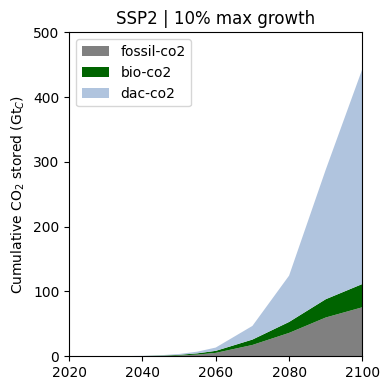

In [47]:
plt.figure(figsize=(4,4))
plt.stackplot(cumulative_storage.columns,
              cumulative_storage.iloc[0],
              cumulative_storage.iloc[1],
              cumulative_storage.iloc[2],
              labels = cumulative_storage.index,
              colors = ["gray","darkgreen","lightsteelblue"]
             )

plt.ylabel("Cumulative CO$_2$ stored (Gt$_C$)")
plt.xlim(2020,2100)
plt.ylim(0,500)
plt.legend(loc="upper left")
plt.title("SSP2 | 10% max growth")
plt.tight_layout()
plt.savefig("cum_co2stored.jpeg",dpi=300)
plt.show()

In [108]:
dums = cumulative_storage[[2100]]
dums = dums.rename(columns={2100:"dums"})
dums

year_act,dums
fossil-co2,114.288884
bio-co2,69.258568
dac-co2,394.508642


In [91]:
dummy = removal[[2025,2030,2035,2040]].drop("World", axis=0)
dummy

year_act,2025,2030,2035,2040
node_loc,,,,
R12_AFR,0.055568,0.182687,0.473490,1.138742
R12_CHN,0.055568,0.182687,0.473490,1.138742
R12_EEU,0.000000,0.000000,0.064213,0.230248
R12_FSU,0.120121,0.419269,1.103612,2.669142
R12_LAM,0.005607,0.262881,0.851433,2.197826
R12_MEA,0.103618,0.425972,1.163402,2.850374
R12_NAM,0.000000,0.471132,1.889071,5.132802
R12_PAO,0.000000,0.006323,0.225623,0.727301
R12_PAS,0.000000,0.113834,0.510467,1.417820


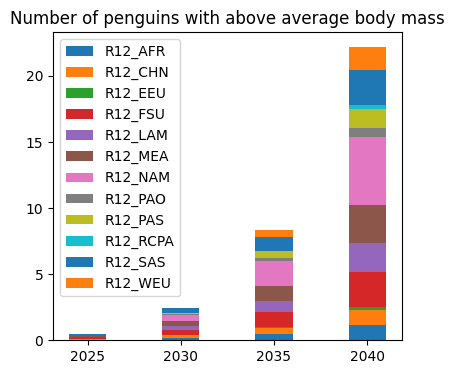

In [97]:
width = 2

fig, ax = plt.subplots(figsize=(4.5,4))
bottom = np.zeros(4)

for reg in dummy.index:
    p = ax.bar(dummy.columns, dummy.loc[reg], width, label=reg, bottom=bottom)
    bottom += dummy.loc[reg]

ax.set_xticks(range(2025,2045,5))
ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper left")

plt.show()

# CO2 Storage SSPs

In [110]:
SSPs = ["SSP1","SSP2","SSP5"]
mpens = ["mpen1","mpen2","mpen3","mpen4","mpen5"]
scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']

stor_scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
             {f"1000f_v0.13_dac-co2split_{mpen}": [] for mpen in mpens} 
             for ssp in SSPs
            }
stor_scenarios

{'SSP_dev_SSP1_v0.1_dac': {'1000f_v0.13_dac-co2split_mpen1': [],
  '1000f_v0.13_dac-co2split_mpen2': [],
  '1000f_v0.13_dac-co2split_mpen3': [],
  '1000f_v0.13_dac-co2split_mpen4': [],
  '1000f_v0.13_dac-co2split_mpen5': []},
 'SSP_dev_SSP2_v0.1_dac': {'1000f_v0.13_dac-co2split_mpen1': [],
  '1000f_v0.13_dac-co2split_mpen2': [],
  '1000f_v0.13_dac-co2split_mpen3': [],
  '1000f_v0.13_dac-co2split_mpen4': [],
  '1000f_v0.13_dac-co2split_mpen5': []},
 'SSP_dev_SSP5_v0.1_dac': {'1000f_v0.13_dac-co2split_mpen1': [],
  '1000f_v0.13_dac-co2split_mpen2': [],
  '1000f_v0.13_dac-co2split_mpen3': [],
  '1000f_v0.13_dac-co2split_mpen4': [],
  '1000f_v0.13_dac-co2split_mpen5': []}}

In [111]:
storage_list = []
for ssp in SSPs:
    for mpen in mpens:
        model = f"SSP_dev_{ssp}_v0.1_dac"
        scenario = f"1000f_v0.13_dac-co2split_{mpen}"
        
        scen = message_ix.Scenario(mp, model=model, scenario=scenario)
        
        removal = (scen.var("ACT", {"technology":"co2_stor"})
           .drop(["technology","year_vtg","time"], axis=1)
           .set_index(["node_loc","year_act","mode"])["lvl"]
          ).swaplevel(1,2).unstack().swaplevel(0,1).groupby(level=[0]).sum()
        removal.index = ["fossil-co2","bio-co2","dac-co2"]
        len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]
        removal = removal.mul(len_periods, axis=1)

        cumulative_storage = removal.cumsum(axis=1).div(1000) # make it GtC
        
        total_stor = cumulative_storage[[2100]]
        total_stor = total_stor.rename(columns={2100:f"{ssp}\n{mpen}"})
        
        storage_list += [total_stor]
        

In [114]:
ssp_total_stor = pd.concat(storage_list, axis=1)
ssp_total_stor

year_act,SSP1\nmpen1,SSP1\nmpen2,SSP1\nmpen3,SSP1\nmpen4,SSP1\nmpen5,SSP2\nmpen1,SSP2\nmpen2,SSP2\nmpen3,SSP2\nmpen4,SSP2\nmpen5,SSP5\nmpen1,SSP5\nmpen2,SSP5\nmpen3,SSP5\nmpen4,SSP5\nmpen5
fossil-co2,95.345160,65.431546,45.213169,40.437350,39.340492,124.383063,104.317000,75.673882,68.847441,67.233644,232.385790,179.964677,114.288884,87.085822,81.740208
bio-co2,71.446325,44.016681,19.705091,15.741218,14.045412,84.730445,59.946864,35.923758,30.805403,28.533532,107.059583,91.815199,69.258568,54.619255,34.836895
dac-co2,99.497432,229.960395,294.588309,300.855717,304.317361,99.516854,232.031293,332.304108,346.450101,351.259810,99.519017,241.056894,394.508642,445.602674,469.559673


In [147]:
mpen_names = ["MP1","MP2","MP3","MP4","MP5"]

ssp1_total_stor = pd.concat(storage_list[0:5], axis=1).transpose()
ssp1_total_stor.index = mpen_names
ssp1_total_stor = ssp1_total_stor.transpose()
ssp2_total_stor = pd.concat(storage_list[5:10], axis=1).transpose()
ssp2_total_stor.index = mpen_names
ssp2_total_stor = ssp2_total_stor.transpose()
ssp5_total_stor = pd.concat(storage_list[10:15], axis=1).transpose()
ssp5_total_stor.index = mpen_names
ssp5_total_stor = ssp5_total_stor.transpose()

ssp_total_stor = [ssp1_total_stor,ssp2_total_stor,ssp5_total_stor]

In [148]:
ssp1_total_stor

,MP1,MP2,MP3,MP4,MP5
fossil-co2,95.345160,65.431546,45.213169,40.437350,39.340492
bio-co2,71.446325,44.016681,19.705091,15.741218,14.045412
dac-co2,99.497432,229.960395,294.588309,300.855717,304.317361


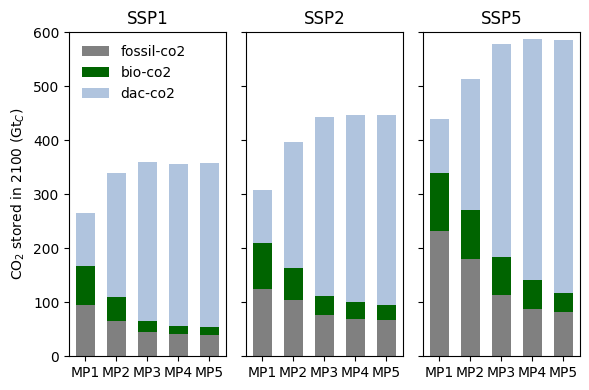

In [153]:
colors = {"fossil-co2":"gray","bio-co2":"darkgreen","dac-co2":"lightsteelblue"}

width = 0.6

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(6,4))
bottom1 = np.zeros(5)
bottom2 = np.zeros(5)
bottom5 = np.zeros(5)

for source in df.index:
    ssp1 = axs[0].bar(ssp1_total_stor.columns, ssp1_total_stor.loc[source], width, label=source, bottom=bottom1,
               color = colors[source]
              )
    ssp2 = axs[1].bar(ssp2_total_stor.columns, ssp2_total_stor.loc[source], width, label=source, bottom=bottom2,
               color = colors[source]
              )
    ssp5 = axs[2].bar(ssp5_total_stor.columns, ssp5_total_stor.loc[source], width, label=source, bottom=bottom5,
               color = colors[source]
              )
    
    bottom1 += ssp1_total_stor.loc[source]
    bottom2 += ssp2_total_stor.loc[source]
    bottom5 += ssp5_total_stor.loc[source]

#ax.set_xticks(range(2025,2045,5))
axs[0].set_title("SSP1")
axs[1].set_title("SSP2")
axs[2].set_title("SSP5")
axs[0].set_ylim(0,600)
axs[0].set_ylabel("CO$_2$ stored in 2100 (Gt$_C$)")
axs[0].legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.savefig("cum_co2stored.jpeg",dpi=300)
plt.show()

## Close connection